# Finer Mesh and Stress Calculation in the 2D TO Algorithm
This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Erin Yu, Sasha Halsey and Ajit Panesar(IDEA Lab, Imperial College London)
- Version: v1 (16/12/2025)
- Comments and corrections to a.panesar@imperial.ac.uk, sasha.halsey20@imperial.ac.uk
-------------------
### Objectives of this lab
1) Run Compliance TO based on finer discretisation
2) Calculate mechanical stress field

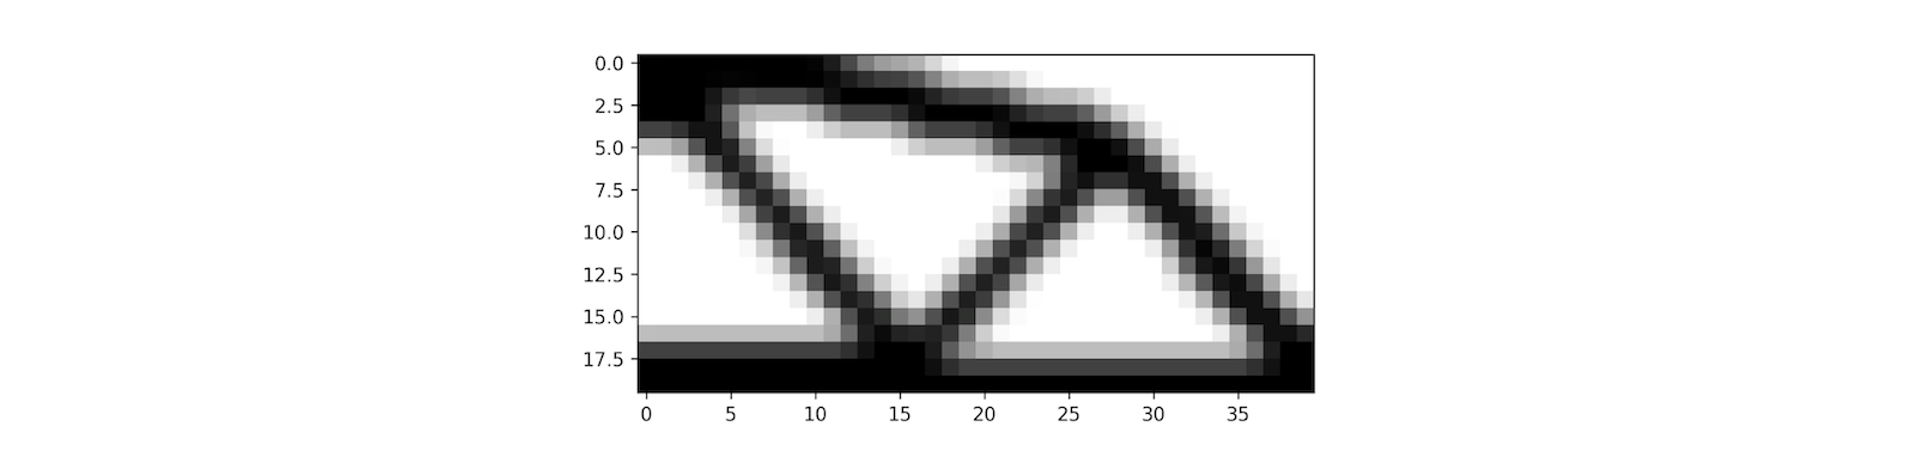

####  Import library

Run the cell below to import necessarry python libraries for this lab.

If you encounter an error, identify the unsuccessfully-installed library name by reading the error message, cut the corresponding pip install statement (without '#' symbol) into a separate cell and run it. Upon running the pip install cell, then restart the kernel and run the (default) import library cell again.

In [1]:
# --- Clone repository from Git
!git clone https://github.com/amberwang56977/Lab.git
%cd Lab

from setup_topology import setup_topology
from iterate_topology import iterate_topology
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import colors
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

Cloning into 'Lab'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 58 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 4.00 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/Lab


-----------
# 1.1) Input parameters

It's YOUR turn to discretise the design domain by defining the number of elements in x and y direction (nelx, nely). More elements will lead to higher resolution but also increasing computational time. You can also define a different target volume fraction, filter radius or penalty to see what changes.
You can change:
- $nelx, nely$
- $rmin$
- $penal$
- $volfrac$

In [2]:
nelx, nely = 40, 20
rmin = 3
penal = 3
Emin, Emax = 1e-9, 1.0
nu = 0.3
volfrac = 0.3
sigma_yield = 1.0 # yield stress

# Define constants & design variables
params = dict(nelx=nelx, nely=nely, rmin=rmin, Emin=Emin, Emax=Emax, nu=nu, penal=penal, volfrac=volfrac)
state = setup_topology(**params)

# iteration parameters
it_params = dict(move=0.2, Emin=params['Emin'], Emax=params['Emax'], penal=params['penal'])

# 1.2) Iterate
This section loops over the optimiser max_iter times. It uses the same functions from Lab (a), cleaned up and call-able, so you don't have to worry about them. You can change the number of iterations and see how it affects the convergence, or change the convergence tolerance with the break clause.

Note: if you change anything in setup_topology.py or iterate_topology.py, you will have to re-start the kernel before you re-run this script.

it   0  obj 1762.1004  change 0.2000
it   1  obj 1113.3758  change 0.2000
it   2  obj 833.8055  change 0.2000
it   3  obj 724.2378  change 0.2000
it   4  obj 657.7865  change 0.2000
it   5  obj 615.5044  change 0.1853
it   6  obj 582.3806  change 0.1674
it   7  obj 555.2211  change 0.1509
it   8  obj 533.3155  change 0.1640
it   9  obj 511.3795  change 0.1247
it  10  obj 493.6807  change 0.1589
it  11  obj 477.8759  change 0.1120
it  12  obj 464.4411  change 0.1181
it  13  obj 451.3354  change 0.0981
it  14  obj 441.6769  change 0.1155
it  15  obj 431.9722  change 0.0872
it  16  obj 423.2587  change 0.1178
it  17  obj 415.7890  change 0.0808
it  18  obj 407.4138  change 0.0961
it  19  obj 399.3059  change 0.1024
it  20  obj 391.5413  change 0.0908
it  21  obj 385.2889  change 0.1035
it  22  obj 377.7380  change 0.1056
it  23  obj 373.0443  change 0.0742
it  24  obj 367.0107  change 0.0853
it  25  obj 361.4536  change 0.0841
it  26  obj 357.2008  change 0.0877
it  27  obj 353.6984  chan

[]

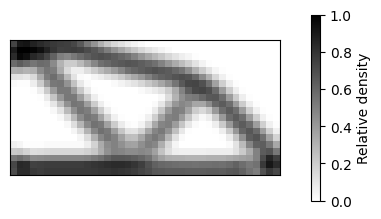

In [3]:
max_iter = 50
for it in range(max_iter):
    state, info = iterate_topology(state, it_params)
    print(f"it {it:3d}  obj {info['obj']:.4f}  change {info['change']:.4f}")
    # optional: visualise every N iters
    # if it % 10 == 0 or info['change'] < 1e-3:
    #     plt.imshow(state['xPhys'].reshape(params['nely'], params['nelx']), cmap='gray_r')
    #     plt.title(f'iter {it}')
    #     plt.pause(0.01)
    if info['change'] < 1e-3:
        break

# Plot density field
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(state['xPhys'].reshape((state['nelx'], state['nely'])).T, cmap='gray_r', interpolation='none',
               norm=colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label('Relative density')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

----------
# 2.1) Calculate stress

The stress in each element is computed from
$$
\boldsymbol{\sigma} = D\,\boldsymbol{\varepsilon}
\qquad\text{with}\qquad
\boldsymbol{\varepsilon} = B\,u_e
$$

where  
- $u_e$ is the element displacement vector,  
- $B$ maps nodal displacements to strain,  
- $D$ defines the constitutive relation.

### Constitutive matrix $D$

For 2D plane-stress, the constitutive matrix is
$$
D
=
\frac{E}{1-\nu^2}
\begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & \tfrac{1-\nu}{2}
\end{bmatrix}
$$

### Strain–displacement matrix $B$

For a 4-node bilinear quadrilateral (Q4) element, the strain is
$$
\boldsymbol{\varepsilon}
=
\begin{bmatrix}
\varepsilon_{xx} \\
\varepsilon_{yy} \\
\gamma_{xy}
\end{bmatrix}
=
B\,u_e
$$

At the element centre, the strain–displacement matrix is
$$
B
=
\frac{1}{4}
\begin{bmatrix}
-1 & 0 & 1 & 0 & 1 & 0 & -1 & 0 \\
0 & -1 & 0 & -1 & 0 & 1 & 0 & 1 \\
-1 & -1 & -1 & 1 & 1 & 1 & 1 & -1
\end{bmatrix}
$$

The element DOF ordering matches
$$
u_e =
[u_{1x},\,u_{1y},\,u_{2x},\,u_{2y},\,u_{3x},\,u_{3y},\,u_{4x},\,u_{4y}]^T
$$

The node positions follow:

        (4)-------(3)
         |         |
         |         |
         |         |
        (1)-------(2)

### Von Mises stress

For a 2D plane-stress state $$\boldsymbol{\sigma} = [\sigma_x,\; \sigma_y,\; \tau_{xy}]^{\mathsf{T}}$$ the von Mises equivalent stress is computed as
$$
\sigma_{\text{vm}}
=
\sqrt{
\sigma_x^2
-
\sigma_x \sigma_y
+
\sigma_y^2
+
3\,\tau_{xy}^2
}
$$

In the implementation, this is evaluated elementwise as $$ \sigma_{\text{vm},e} $$ using the stresses obtained from $$\boldsymbol{\sigma}_e = D\,B\,u_e$$

To obtain a non-dimensional stress measure, the von Mises stress is normalised by the yield stress
$\sigma_{\text{yield}}$:
$$
\hat{\sigma}_{\text{vm}}
=
\frac{\sigma_{\text{vm}}}{\sigma_{\text{yield}}}
$$
This normalisation ensures that $\hat{\sigma}_{\text{vm}} = 1$ corresponds to the onset of yielding, which simplifies comparison across elements and allows the stress measure to be used consistently in constraint or objective formulations.


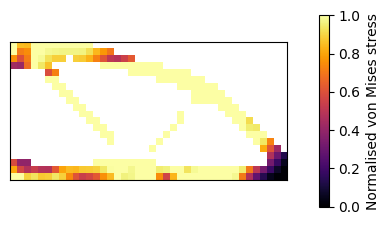

In [4]:
U = state['u'][:, 0]
edofMat = state['edofMat']
nu = state['nu']
Emax = state['Emax']

# plane stress matrix
D = (Emax/(1 - nu**2)) * np.array([
    [1,   nu,       0],
    [nu,  1,        0],
    [0,   0,  (1 - nu)/2]])

B = 0.25 * np.array([
    [-1, 0,  1, 0,  1, 0, -1, 0],
    [0, -1,  0,-1,  0, 1,  0, 1],
    [-1,-1, -1, 1,  1, 1,  1,-1]])

nel = state['nelx'] * state['nely']
sigma_elem = np.zeros((nel, 3))
sigma_vm = np.zeros(nel)

for el in range(nel):
    edofs = edofMat[el]
    u_e = U[edofs]

    eps = B @ u_e
    sig = D @ eps
    sigma_elem[el, :] = sig

    sx, sy, txy = sig
    sigma_vm[el] = (1 / sigma_yield) * (np.sqrt(sx*sx - sx*sy + sy*sy + 3*txy*txy))

# reshape to grid
sigma_vm_grid = np.flip(sigma_vm.reshape((state['nelx'], state['nely'])).T, axis=0)

# density grid
density_grid = state['xPhys'].reshape((state['nelx'], state['nely'])).T

# mask low-density regions
stress_masked = np.flip(np.where(density_grid >= 0.5, sigma_vm_grid, np.nan),axis=0)

# plot
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(stress_masked, cmap="inferno", interpolation="none", origin="lower", vmin=0.0, vmax=1.0)
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label("Normalised von Mises stress")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

<h3><font color="lightblue">2.2) Optional: Calculate stress and distortion due to temperature change</font></h3>

### Thermal Strain

For a temperature change $\Delta T = T - T_0$ and thermal expansion coefficient $\alpha$:
$$
\varepsilon_{\text{therm}} = \alpha\,\Delta T\,
\begin{bmatrix}
1 \\[4pt]
1 \\[4pt]
0
\end{bmatrix}
$$


### Total Strain = Mechanical + Thermal
$$\varepsilon_{\text{total}} = \varepsilon_{\text{mech}} + \varepsilon_{\text{therm}}$$

The plane–stress constitutive matrix is
$$
D = \frac{E}{1-\nu^{2}}
\begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & \frac{1-\nu}{2}
\end{bmatrix}
$$
Thus stress in each element is
$$
\sigma = D\left( \varepsilon_{\text{mech}} - \varepsilon_{\text{therm}} \right)
$$


### Equivalent Thermal Nodal Load
The thermal strain induces an equivalent nodal load:
$$
f_{\text{therm}} = \int B^{T} D\,\varepsilon_{\text{therm}}\, dA
$$

For a bilinear quad evaluated at the element center:
$$
f_{\text{therm}} = B^{T} D\,\varepsilon_{\text{therm}}
$$

In [6]:
# pull things from state
nelx  = state['nelx']
nely  = state['nely']
edofMat = state['edofMat']
u = state['u']
f = state['f']
free = state['free']
nu = state['nu']
Emax = state['Emax']

# thermal parameters
alpha = 1e-5
T0 = 20
T = 100
dT = T - T0

# material matrix
D = (Emax / (1 - nu**2)) * np.array([
    [1,   nu,       0],
    [nu,  1,        0],
    [0,   0,  (1 - nu)/2]])

# strain-displacement matrix at element center
B_center = 0.25 * np.array([
    [-1,0, 1,0, 1,0, -1,0],
    [0,-1, 0,-1, 0,1, 0,1],
    [-1,-1, -1,1, 1,1, 1,-1]])

nel = nelx * nely
sigma_elem = np.zeros((nel, 3))
sigma_vm   = np.zeros(nel)

# loop over elements
for e in range(nel):

    # element DOFs already known
    dofs = edofMat[e]

    # extract element displacement
    u_e = u[dofs, 0]

    # mechanical strain
    eps_mech = B_center @ u_e

    # thermal strain
    eps_therm = alpha * dT * np.array([1, 1, 0])

    # stress
    sig_e = D @ (eps_mech - eps_therm)
    sigma_elem[e, :] = sig_e

    # von Mises
    sx, sy, txy = sig_e
    sigma_vm[e] = np.sqrt(sx*sx - sx*sy + sy*sy + 3*txy*txy)

    # thermal equivalent nodal load
    f_therm_e = B_center.T @ (D @ eps_therm)
    f[dofs, 0] += f_therm_e

# ——— Re-solve for thermal displacement ———
# (You must recompute stiffness K the same way as in iterate_topology)
# K = <assemble stiffness same as iterate_topology>

# u[free, 0] = spsolve(K[free][:, free], f[free, 0])